<a href="https://colab.research.google.com/github/sunpau/ERA_V1/blob/main/S11/S11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/ML_assignment/ERA_V1/ERA_V1/S11/S11/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ML_assignment/ERA_V1/ERA_V1/S11/S11


## Requirements

In [ ]:
!pip install torchsummary
!pip install torch_lr_finder
!pip install grad-cam

## Device

In [ ]:
from utils import get_device
is_cuda_available, device = get_device()
print(is_cuda_available, device)

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


True cuda


In [ ]:
#get the transforms, the data and then load the data
from transform import get_a_train_transform, get_a_test_transform
from dataset import Cifar10Dataset, get_loader

train_transform = get_a_train_transform()
test_transform = get_a_test_transform()

train_data = Cifar10Dataset(root='../data', train=True, download=True, transforms=train_transform)
test_data = Cifar10Dataset(root='../data', train=False, download=True, transforms=test_transform)

batch_size=512
train_loader, test_loader = get_loader(train_data, test_data, batch_size=batch_size, use_cuda=True)

#mapping the index to respective classes
class_map = {
    0: 'plane',
    1: 'car',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

Files already downloaded and verified
Files already downloaded and verified


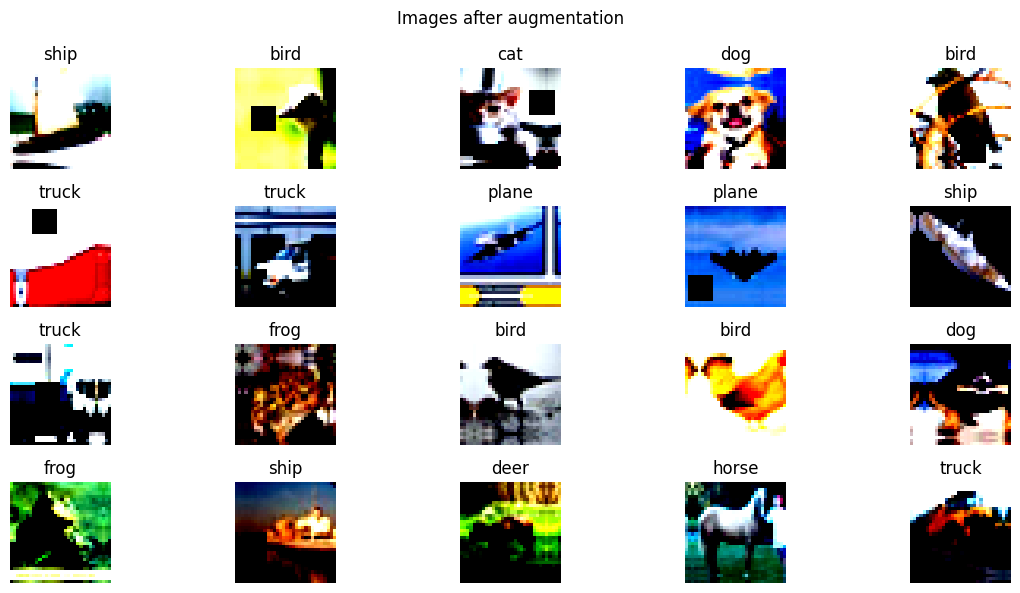

In [ ]:
#visualize the data after augmentation
from utils import visualize_augmentations
data, label = next(iter(train_loader))
visualize_augmentations(data, label, 'Images after augmentation', class_map, samples=20, cols=5)

In [ ]:
from models.resnet import ResNet18
from utils import print_model_summary

model = ResNet18().to(device)
print_model_summary(model, device, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 18, 18]           1,728
              ReLU-2           [-1, 64, 18, 18]               0
       BatchNorm2d-3           [-1, 64, 18, 18]             128
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
            Block-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [ ]:
# get the model
import torch.nn as nn
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.02, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.30E-02


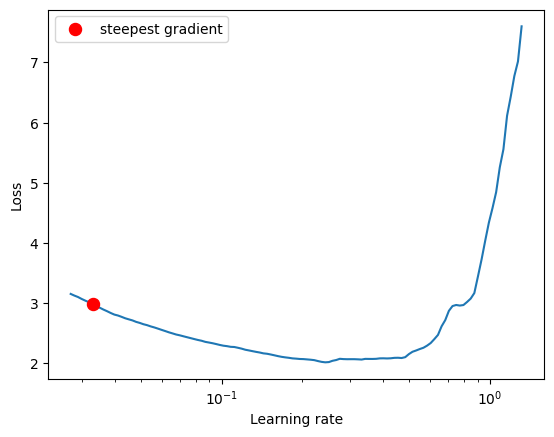

In [ ]:
from utils import lr_finder
lr_finder(model, train_loader, optimizer, criterion, device)

In [ ]:
from train_test import *
from utils import print_epoch_progress


num_epochs = 20
scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr= 3.30E-02, #2.91E-02, #4.02E-02
        steps_per_epoch=len(train_loader),
        epochs=num_epochs,
        pct_start=0.25,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear'
    )

train_losses, train_accuracy, test_losses, test_accuracy, lr = training(model, device, num_epochs, train_loader, test_loader, optimizer,criterion,scheduler)

| Epoch | LR       | TrainAcc  | TrainLoss | TestAcc   | TestLoss |
|     1 | 0.006877 | 43.838  % | 1.534224  | 49.76   % | 1.355533 |
|     2 | 0.013425 | 55.178  % | 1.249051  | 54.77   % | 1.24329  |
|     3 | 0.019972 | 60.504  % | 1.116951  | 51.99   % | 1.401796 |
|     4 | 0.026519 | 63.834  % | 1.027758  | 56.46   % | 1.327763 |
|     5 | 0.032978 | 66.036  % | 0.97249   | 52.97   % | 1.590877 |
|     6 | 0.030778 | 67.498  % | 0.930341  | 62.97   % | 1.085942 |
|     7 | 0.028578 | 69.806  % | 0.870289  | 55.68   % | 1.434233 |
|     8 | 0.026378 | 71.364  % | 0.822925  | 71.22   % | 0.825268 |
|     9 | 0.024178 | 72.216  % | 0.800875  | 62.62   % | 1.110674 |
|    10 | 0.021979 | 73.444  % | 0.767347  | 74.83   % | 0.761061 |
|    11 | 0.019779 | 74.282  % | 0.742111  | 69.66   % | 0.93444  |
|    12 | 0.017579 | 74.872  % | 0.721513  | 73.13   % | 0.808854 |
|    13 | 0.015379 | 75.778  % | 0.70285   | 74.11   % | 0.77563  |
|    14 | 0.01318  | 76.526  % | 0.674379  | 74.

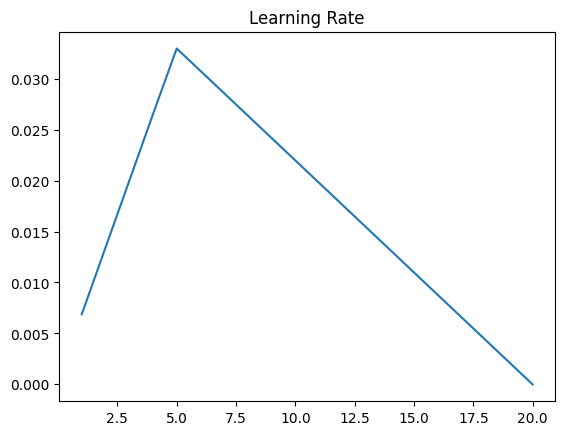

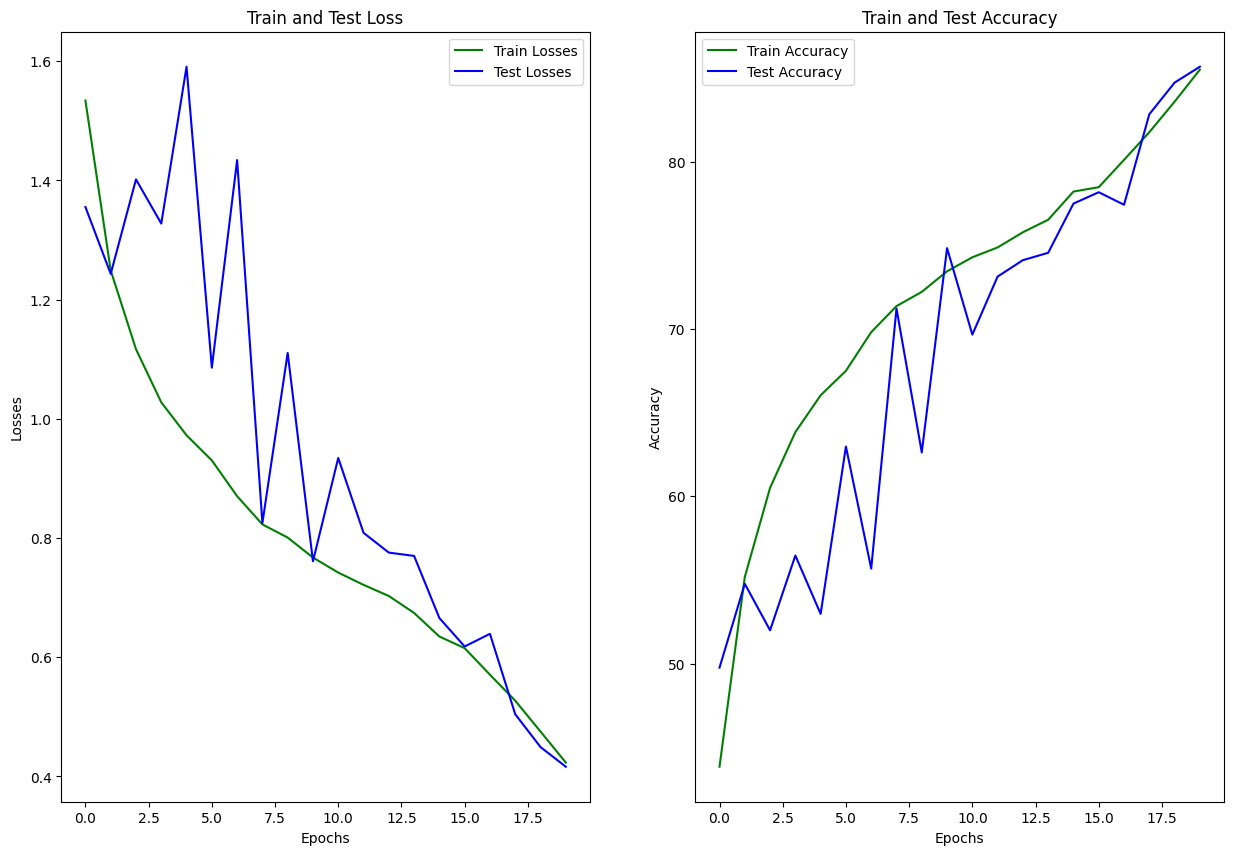

In [ ]:
from utils import overplot_loss_accuracy, plot_lr
plot_lr(num_epochs, lr)
overplot_loss_accuracy(train_losses, test_losses, train_accuracy, test_accuracy)

Total Incorrect Predictions 1433


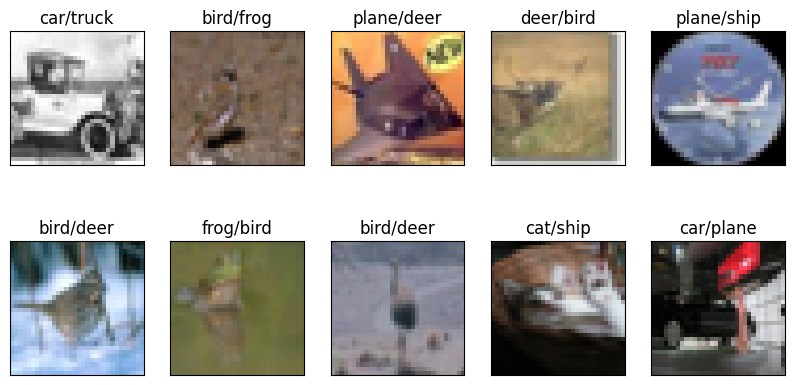

In [ ]:
from utils import get_incorrrect_predictions, plot_incorrect_predictions
incorrect_prdeictions = get_incorrrect_predictions(model, test_loader, device, criterion)
plot_incorrect_predictions(incorrect_prdeictions, class_map, 10)

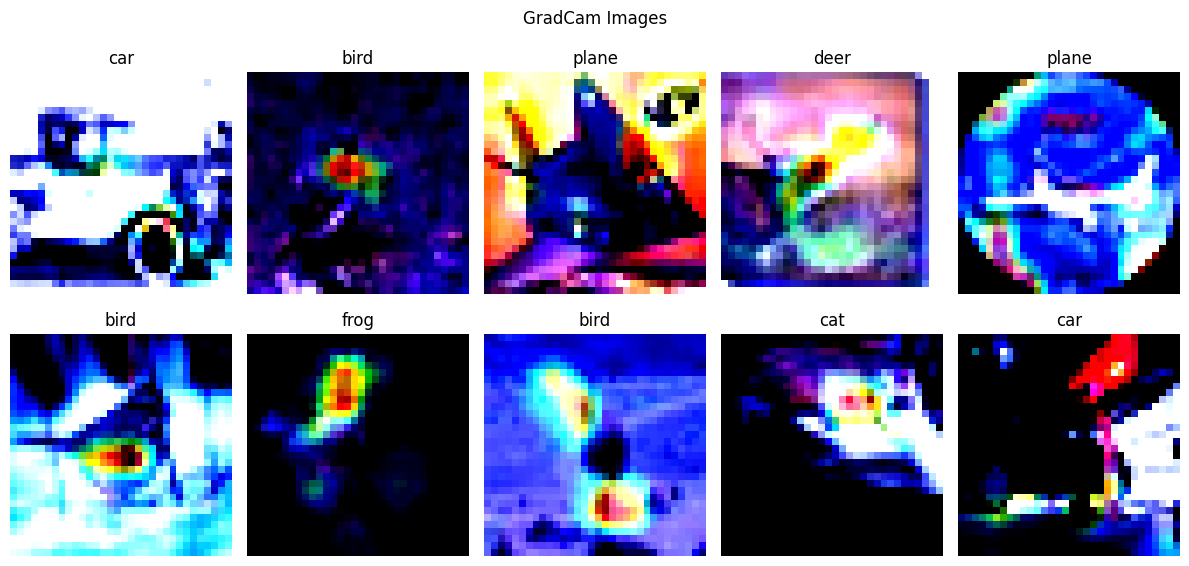

In [ ]:
from utils import misclassifieddata, plot_grad_cam
import matplotlib.pyplot as plt
import numpy as np
misclsdata, misclstarget, misclspred = misclassifieddata(incorrect_prdeictions[0:10])
target_layers = [model.layer4[-1]]
plot_grad_cam(misclsdata, misclstarget, misclspred, model, device, target_layers, 'GradCam Images', class_map, samples=10, cols=5)

In [ ]:
# torch.save(model.state_dict(), 'resnet18model_weights.pth')

In [ ]:
# import torch
# model.load_state_dict(torch.load('resnet18model_weights.pth',map_location=device))
# model.eval()

ResNet(
  (prep): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): Block(
      (relu): ReLU()
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): Block(
      (relu): ReLU()
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
